In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from collections import Counter
from itertools import product
from time import time
from tqdm import tqdm

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import random
import os

# random.seed(42)

def create_Dataframe(df, citation, starting_year = 1893, final_year = 2016, col_name = "MAGAuthorsID"):
    metadata_df = df.query("year >= @starting_year and year < @final_year")
    metadata_df = metadata_df[['doi', col_name, 'year']].reset_index(drop=True)
    
    citing_df = pd.merge(metadata_df, citation, left_on = "doi"
            , right_on = "citing_doi", how = "inner", validate = "one_to_many")

    citing_cited_df = pd.merge(citing_df, metadata_df, left_on = "cited_doi"
            , right_on = "doi", how = "inner", suffixes = ["_citing", "_cited"])
    
    citing_cited_df = citing_cited_df.drop_duplicates(keep = 'first')
    citing_cited_df = citing_cited_df.reset_index(drop = True)
    return citing_cited_df

def create_edge_list(df, citation, starting_year, final_year, top_set):
    
    def edges_by_df(x, y, author_list):
        x = set(x.split(",")).intersection(author_list)
        y = set(y.split(",")).intersection(author_list)
        if ((len(x) != 0) or (len(y) != 0)):
            return list(product(x, y))
        else:
            return None
    
    citations = create_Dataframe(df, citation, starting_year = starting_year
                                                        , final_year = final_year)
    lista_edges = citations.apply(lambda x : edges_by_df(x['MAGAuthorsID_citing']
                                    , x['MAGAuthorsID_cited'], top_set), axis = 1)
    lista_edges = [i for i in lista_edges if i is not None]
    flat_list = [item for sublist in lista_edges for item in sublist]
    return flat_list

def get_publications_by_author(df, column_id = "MAGAuthorsID"):
    author_list = [item for list_ in df[column_id].tolist() for item in (list_).split(",")]
    counter_publishes_df = pd.DataFrame.from_dict(Counter(author_list), orient = "index")
    counter_publishes_df = counter_publishes_df.reset_index().sort_values(0, ascending = False)
    counter_publishes_df = counter_publishes_df.reset_index(drop = True)
    counter_publishes_df.columns = [column_id, "Publication"]
    return counter_publishes_df

def double_list(lista_):
    lista_temp = [ (pair[1], pair[0]) for pair in lista_]
    return lista_ + lista_temp

def preprocess_graph(G, to_undirected = True, remove_selfloop = True, major_component = True, relabel = True):
    if to_undirected:
        G = G.to_undirected()
    if remove_selfloop:
        G.remove_edges_from(nx.selfloop_edges(G))
    if major_component:
        Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
        G = G.subgraph(Gcc[0])
    if relabel:
        G = nx.convert_node_labels_to_integers(G, first_label=0)
    return G

In [3]:
import os

os.chdir(r'/content/drive/MyDrive/Link Prediction - 1k -  fair')

In [76]:
init_year = 1970
mid_year = 2000
end_year = 2017
N_top = 1000

col_feature = "MAGAuthorsID"

citation = pd.read_csv("citation-data/aps-dataset-citations-2018.csv", encoding = "utf8")

df = pd.read_csv('citation-data/WOS_aut_ord.csv', sep = ';', encoding = 'utf-8')
df = df[df['Author-ord'] != 'None']
df = df[df['MAGAuthorsID'] != 'None']

df_train = df[(df['year'] >= init_year) & (df['year'] < mid_year)].copy()
train_authors_publications = get_publications_by_author(df_train
                                                , column_id = col_feature)
df_test = df[(df['year'] >= mid_year)].copy()
test_authors_publications = get_publications_by_author(df_test
                                                , column_id = col_feature)

top_publisher = test_authors_publications.join(train_authors_publications.set_index(col_feature)
                        , on = col_feature, rsuffix = '_').dropna()#


In [77]:
len(top_publisher)

43295

In [78]:
train_authors_publications.Publication = train_authors_publications.Publication.astype(int)

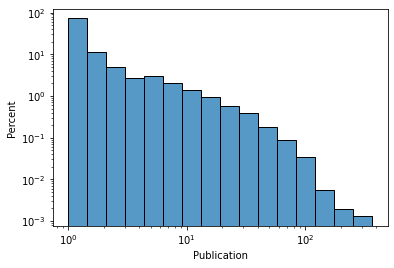

In [108]:
import seaborn as sns

sns.histplot(train_authors_publications, x = "Publication"
                , log_scale = [True, True]
                , bins = 16
                , stat = "percent"
                , element = "bars")

In [81]:
top_publisher.columns = ["Author ID", "Test", "Train"]

In [82]:
melt_publishers = pd.melt(top_publisher, id_vars = ["Author ID"], value_vars = ["Test", "Train"])
melt_publishers.columns = ["Author ID", "Dataset", "Number of Publications"]
melt_publishers.head(5)

,Author ID,Dataset,Number of Publications
0,2134797622,Test,395.0
1,2021417135,Test,391.0
2,2085131248,Test,319.0
3,379423047,Test,305.0
4,2106373458,Test,283.0


In [83]:
melt_publishers.groupby("Dataset").mean()

,Number of Publications
Dataset,
Test,9.769073
Train,6.708927


In [84]:
melt_publishers.groupby("Dataset").std()

,Number of Publications
Dataset,
Test,15.761034
Train,11.454935


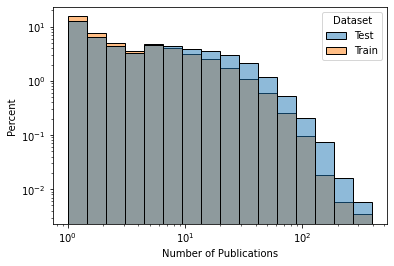

In [107]:
sns.histplot(melt_publishers
                , x = "Number of Publications"
                , hue = "Dataset"
                , log_scale = [True, True]
                , bins = 16
                , stat = "percent"
                , element = "bars"
)
# plt.xlim(0, 40)

In [74]:
print(train_authors_publications.shape[0])
print(test_authors_publications.shape[0])
print(top_publisher.shape[0])

304674
345801
43295


In [ ]:
top_10k_set = set(top_publisher.head(N_top)[col_feature])

edge_list_train = create_edge_list(df, citation, starting_year = init_year
                            , final_year = mid_year, top_set = top_10k_set)

edge_list_train = double_list(edge_list_train)
edges_weight = Counter(edge_list_train)
edges_df = pd.DataFrame.from_dict(edges_weight, orient = "index") 
edges_df = edges_df.reset_index()
edges_df["source"] = edges_df.apply(lambda x : x["index"][0], axis = 1)
edges_df["target"] = edges_df.apply(lambda x : x["index"][1], axis = 1)
edges_df.drop("index", axis = 1, inplace = True)
edges_df.columns = ["weight", "source", "target"]

In [ ]:
G_TRAIN = nx.from_pandas_edgelist(edges_df, "source", "target", ["weight"]
                                                      , create_using = nx.Graph())
print("nodes", len(G_TRAIN.nodes()), "edges", len(G_TRAIN.edges()))

nodes 988 edges 20998


In [ ]:
G_TRAIN = preprocess_graph(G_TRAIN, to_undirected = True, remove_selfloop = True
                                         , major_component = True, relabel = False)
print("nodes", len(G_TRAIN.nodes()), "edges", len(G_TRAIN.edges()))

nodes 981 edges 20120


In [ ]:
nx.write_gpickle(G_TRAIN, "graphs/G_TRAIN_FULL_1970_2000.gpickle")

In [ ]:
G_TRAIN = nx.Graph(G_TRAIN)

In [ ]:
training_percent = 0.2
training_size = int(training_percent * len(G_TRAIN.edges()))

lista_edges_train = G_TRAIN.edges()
lista_non_edges_train = list(nx.non_edges(G_TRAIN))

edges_neg = random.sample(lista_non_edges_train, training_size)
edges_pos = random.sample(lista_edges_train, training_size)
G_TRAIN.remove_edges_from(edges_pos)

nx.write_gpickle(G_TRAIN, "graphs/G_TRAIN_REM_1970_2000.gpickle")

pkl_df_train = pd.DataFrame({
  "edges": edges_pos + edges_neg
  , "y" : len(edges_pos) * [1] + len(edges_neg) * [0]
})

pkl_df_train.to_pickle("dataframes/df_TRAIN_1970_2000.pkl")

In [ ]:
top_10k_test_set = list(G_TRAIN.nodes())

In [ ]:
middle_year = 2000
final_year = 2016

df_edge_test = pd.DataFrame(columns = ["edges", "year", "y"])

for lim_sup in tqdm(range(middle_year+1, final_year+1)):
    edge_test = create_edge_list(df, citation, starting_year = 2000
                            , final_year = lim_sup + 0.001, top_set = top_10k_test_set)

    G = nx.Graph()
    G.add_edges_from(edge_test)
    G.remove_edges_from(nx.selfloop_edges(G))
    edge_test = list(set(G.edges()) - set(edge_list_train))
    
    df_edge_temp = pd.DataFrame(columns = ["edges", "year", "y"])
    df_edge_temp["edges"] = edge_test
    df_edge_temp["year"] = lim_sup
    df_edge_temp["y"] = 1
    
    df_edge_test = pd.concat([df_edge_test, df_edge_temp], ignore_index = True)
    df_edge_test.drop_duplicates(subset = ["edges"], keep = "first", inplace = True, ignore_index = True)

100%|██████████| 16/16 [20:34<00:00, 77.14s/it] 


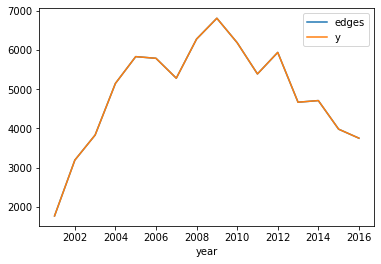

In [ ]:
df_edge_test.groupby("year").count().plot()

In [ ]:
df_edge_test.groupby("year").count()

,edges,y
year,,
2001,1766,1766
2002,3190,3190
2003,3831,3831
2004,5149,5149
2005,5833,5833
2006,5790,5790
2007,5282,5282
2008,6282,6282
2009,6813,6813


In [ ]:
pos_edges = set(df_edge_test.edges.tolist())
non_edges = list(set(list(nx.non_edges(G_TRAIN))) - pos_edges)
r_non_edges = random.sample(non_edges, len(pos_edges))

df_temp_non_edges = pd.DataFrame(columns = ["edges", "year", "y"])
df_temp_non_edges["edges"] =  r_non_edges
df_temp_non_edges["year"] = 9999
df_temp_non_edges["y"] = 0
df_temp_non_edges

,edges,year,y
0,"(1966089654, 2102240352)",9999,0
1,"(2095146129, 1989764689)",9999,0
2,"(2346160810, 2172644512)",9999,0
3,"(2116981010, 2093490409)",9999,0
4,"(2159084566, 2093430819)",9999,0
...,...,...,...
78564,"(2472878894, 2422950260)",9999,0
78565,"(2070953463, 2478624925)",9999,0
78566,"(2048746224, 2153856636)",9999,0
78567,"(2423670809, 38343657)",9999,0


In [ ]:
df_edge_test = pd.concat([df_edge_test, df_temp_non_edges], ignore_index = True)

In [ ]:
df_edge_test.groupby("year").count()

,edges,y
year,,
2001,1766,1766
2002,3190,3190
2003,3831,3831
2004,5149,5149
2005,5833,5833
2006,5790,5790
2007,5282,5282
2008,6282,6282
2009,6813,6813


In [ ]:
df_edge_test.query("year != 9999").count()

edges    78569
year     78569
y        78569
dtype: int64

In [ ]:
df_edge_test.count()

edges    157138
year     157138
y        157138
dtype: int64

In [ ]:
df_edge_test.to_pickle("dataframes/df_TEST_2000_2016.pkl")